In [5]:
import argparse
import os
import random
import scipy as sp
import pickle
import sys

import shutil
import csv
import ast


import matplotlib.pyplot as plt
import scipy.sparse as sparse
from tqdm import tqdm
from torch import Tensor
import networkx as nx
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
from torch_geometric.data import Data

import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from autoencoder import VariationalAutoEncoder
from denoise_model import DenoiseNN, p_losses, sample
from utils_ipynb import linear_beta_schedule, construct_nx_from_adj, preprocess_dataset, graph_statistics
from scipy.stats import zscore



from torch.utils.data import Subset
np.random.seed(13)



In [6]:
%load_ext autoreload
%autoreload 2

In [9]:

import argparse
import sys

# Simulate command-line arguments
sys.argv = [
    'main.py',
    '--lr', '0.001',
    '--dropout', '0.1',
    '--batch-size', '256',
    '--epochs-autoencoder', '200',
    '--hidden-dim-encoder', '64',
    '--hidden-dim-decoder', '256',
    '--latent-dim', '32',
    '--n-max-nodes', '50',
    '--n-layers-encoder', '2',
    '--n-layers-decoder', '3',
    '--spectral-emb-dim', '10',
    '--epochs-denoise', '100',
    '--timesteps', '500',
    '--hidden-dim-denoise', '512',
    '--n-layers_denoise', '3',
    # '--train-autoencoder',
    '--train-denoiser',
    '--dim-condition', '128',
    '--n-condition', '7'
]

# Initialize the parser
parser = argparse.ArgumentParser(description="Your description here")

# Add arguments
parser.add_argument('--lr', type=float, default=1e-3, help="Learning rate for the optimizer, typically a small float value (default: 0.001)")
parser.add_argument('--dropout', type=float, default=0.0, help="Dropout rate (fraction of nodes to drop) to prevent overfitting (default: 0.0)")
parser.add_argument('--batch-size', type=int, default=256, help="Batch size for training, controlling the number of samples per gradient update (default: 256)")
parser.add_argument('--epochs-autoencoder', type=int, default=200, help="Number of training epochs for the autoencoder (default: 200)")
parser.add_argument('--hidden-dim-encoder', type=int, default=64, help="Hidden dimension size for encoder layers (default: 64)")
parser.add_argument('--hidden-dim-decoder', type=int, default=256, help="Hidden dimension size for decoder layers (default: 256)")
parser.add_argument('--latent-dim', type=int, default=32, help="Dimensionality of the latent space in the autoencoder (default: 32)")
parser.add_argument('--n-max-nodes', type=int, default=50, help="Possible maximum number of nodes in graphs (default: 50)")
parser.add_argument('--n-layers-encoder', type=int, default=2, help="Number of layers in the encoder network (default: 2)")
parser.add_argument('--n-layers-decoder', type=int, default=3, help="Number of layers in the decoder network (default: 3)")
parser.add_argument('--spectral-emb-dim', type=int, default=10, help="Dimensionality of spectral embeddings for representing graph structures (default: 10)")
parser.add_argument('--epochs-denoise', type=int, default=100, help="Number of training epochs for the denoising model (default: 100)")
parser.add_argument('--timesteps', type=int, default=500, help="Number of timesteps for the diffusion (default: 500)")
parser.add_argument('--hidden-dim-denoise', type=int, default=512, help="Hidden dimension size for denoising model layers (default: 512)")
parser.add_argument('--n-layers_denoise', type=int, default=3, help="Number of layers in the denoising model (default: 3)")
parser.add_argument('--train-autoencoder', action='store_true', default=False, help="Flag to enable/disable autoencoder (VGAE) training (default: enabled)")
parser.add_argument('--train-denoiser', action='store_true', default=False, help="Flag to enable/disable denoiser training (default: enabled)")
parser.add_argument('--dim-condition', type=int, default=128, help="Dimensionality of conditioning vectors for conditional generation (default: 128)")
parser.add_argument('--n-condition', type=int, default=7, help="Number of distinct condition properties used in conditional vector (default: 7)")

# Parse the arguments
args = parser.parse_args()

# Use the arguments as needed
print(args)

Namespace(lr=0.001, dropout=0.1, batch_size=256, epochs_autoencoder=200, hidden_dim_encoder=64, hidden_dim_decoder=256, latent_dim=32, n_max_nodes=50, n_layers_encoder=2, n_layers_decoder=3, spectral_emb_dim=10, epochs_denoise=100, timesteps=500, hidden_dim_denoise=512, n_layers_denoise=3, train_autoencoder=False, train_denoiser=True, dim_condition=128, n_condition=7)


In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# preprocess train data, validation data and test data. Only once for the first time that you run the code. Then the appropriate .pt files will be saved and loaded.
trainset = preprocess_dataset("train", args.n_max_nodes, args.spectral_emb_dim)
validset = preprocess_dataset("valid", args.n_max_nodes, args.spectral_emb_dim)
testset = preprocess_dataset("test", args.n_max_nodes, args.spectral_emb_dim)

# initialize data loaders
train_loader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(validset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=args.batch_size, shuffle=False)


/users/eleves-b/2021/valentin.dorseuil/Desktop/altegrad_project/new_loss/utils_ipynb.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)


Dataset ../data/dataset_train.pt loaded from file
Dataset ../data/dataset_valid.pt loaded from file
Dataset ../data/dataset_test.pt loaded from file


/users/eleves-b/2021/valentin.dorseuil/Desktop/altegrad_project/new_loss/utils_ipynb.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)


In [10]:
# initialize VGAE model
autoencoder = VariationalAutoEncoder(args.spectral_emb_dim+1, args.hidden_dim_encoder, args.hidden_dim_decoder, args.latent_dim, args.n_layers_encoder, args.n_layers_decoder, args.n_max_nodes).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

total_params_vae = sum(p.numel() for p in autoencoder.parameters())
print(total_params_vae)

if args.train_autoencoder:
    best_val_loss = np.inf
    for epoch in range(1, args.epochs_autoencoder+1):
        autoencoder.train()
        train_loss_all = 0
        train_count = 0
        train_loss_all_recon = 0
        train_loss_all_kld = 0
        cnt_train=0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            loss, recon, kld  = autoencoder.loss_function(data)
            train_loss_all_recon += recon.item()
            train_loss_all_kld += kld.item()
            cnt_train+=1
            loss.backward()
            train_loss_all += loss.item()
            train_count += torch.max(data.batch)+1
            optimizer.step()

        autoencoder.eval()
        val_loss_all = 0
        val_count = 0
        cnt_val = 0
        val_loss_all_recon = 0
        val_loss_all_kld = 0

        for data in val_loader:
            data = data.to(device)
            loss, recon, kld  = autoencoder.loss_function(data)
            val_loss_all_recon += recon.item()
            val_loss_all_kld += kld.item()
            val_loss_all += loss.item()
            cnt_val+=1
            val_count += torch.max(data.batch)+1

        if epoch % 1 == 0:
            dt_t = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
            print('{} Epoch: {:04d}, Train Loss: {:.5f}, Train Reconstruction Loss: {:.2f}, Train KLD Loss: {:.2f}, Val Loss: {:.5f}, Val Reconstruction Loss: {:.2f}, Val KLD Loss: {:.2f}'.format(dt_t,epoch, train_loss_all/cnt_train, train_loss_all_recon/cnt_train, train_loss_all_kld/cnt_train, val_loss_all/cnt_val, val_loss_all_recon/cnt_val, val_loss_all_kld/cnt_val))
            
        scheduler.step()

        if best_val_loss >= val_loss_all:
            best_val_loss = val_loss_all
            torch.save({
                'state_dict': autoencoder.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, '../models/autoencoder.pth.tar')
else:
    checkpoint = torch.load('../models/autoencoder_sum.pth.tar')
    autoencoder.load_state_dict(checkpoint['state_dict'])

    autoencoder.eval()

721682


/tmp/ipykernel_2429729/755764236.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../models/autoencoder_sum.pth.tar')


RuntimeError: Error(s) in loading state_dict for VariationalAutoEncoder:
	Missing key(s) in state_dict: "encoder.mu.weight", "encoder.mu.bias", "encoder.logvar.weight", "encoder.logvar.bias". 
	Unexpected key(s) in state_dict: "fc_mu.weight", "fc_mu.bias", "fc_logvar.weight", "fc_logvar.bias", "encoder.fc.weight", "encoder.fc.bias". 

In [11]:
# define beta schedule
betas = linear_beta_schedule(timesteps=args.timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# initialize denoising model
denoise_model = DenoiseNN(input_dim=args.latent_dim, hidden_dim=args.hidden_dim_denoise, n_layers=args.n_layers_denoise, n_cond=args.n_condition, d_cond=args.dim_condition).to(device)
optimizer = torch.optim.Adam(denoise_model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

total_params_denoiser = sum(p.numel() for p in denoise_model.parameters())
print(total_params_denoiser)

# Train denoising model
if args.train_denoiser:
    best_val_loss = np.inf
    for epoch in range(1, args.epochs_denoise+1):
        denoise_model.train()
        train_loss_all = 0
        train_count = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            x_g = autoencoder.encode(data)
            t = torch.randint(0, args.timesteps, (x_g.size(0),), device=device).long()
            loss = p_losses(denoise_model, x_g, t, data.stats, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, loss_type="huber")
            loss.backward()
            train_loss_all += x_g.size(0) * loss.item()
            train_count += x_g.size(0)
            optimizer.step()

        denoise_model.eval()
        val_loss_all = 0
        val_count = 0
        for data in val_loader:
            data = data.to(device)
            x_g = autoencoder.encode(data)
            t = torch.randint(0, args.timesteps, (x_g.size(0),), device=device).long()
            loss = p_losses(denoise_model, x_g, t, data.stats, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, loss_type="huber")
            val_loss_all += x_g.size(0) * loss.item()
            val_count += x_g.size(0)

        if epoch % 5 == 0:
            dt_t = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
            print('{} Epoch: {:04d}, Train Loss: {:.5f}, Val Loss: {:.5f}'.format(dt_t, epoch, train_loss_all/train_count, val_loss_all/val_count))

        scheduler.step()

        if best_val_loss >= val_loss_all:
            best_val_loss = val_loss_all
            torch.save({
                'state_dict': denoise_model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, '../models/denoise_model.pth.tar')
else:
    checkpoint = torch.load('../models/denoise_model_sum.pth.tar')
    denoise_model.load_state_dict(checkpoint['state_dict'])

    denoise_model.eval()



971936
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
torch.Size([256, 32]) torch.Size([256, 128])
tor

KeyboardInterrupt: 

In [8]:
from sklearn.metrics import mean_absolute_error
from scipy.stats import zscore


ground_truth = []
pred = []

for k, data in enumerate(tqdm(test_loader, desc='Processing test set',)):
    data = data.to(device)
    stat = data.stats
    bs = stat.size(0)
    samples = sample(denoise_model, data.stats, latent_dim=args.latent_dim, timesteps=args.timesteps, betas=betas, batch_size=bs)
    x_sample = samples[-1]
    adj = autoencoder.decode_mu(x_sample)
    stat_d = torch.reshape(stat, (-1, args.n_condition))

    for i in range(stat.size(0)):
        #adj = autoencoder.decode_mu(samples[random_index])
        # Gs_generated.append(construct_nx_from_adj(adj[i,:,:].detach().cpu().numpy()))
        stat_x = stat_d[i]

        Gs_generated = construct_nx_from_adj(adj[i,:,:].detach().cpu().numpy())
        stat_x = stat_x.detach().cpu().numpy()

        ground_truth.append(stat_x)
        pred.append(graph_statistics(Gs_generated))
            

ground_truth = np.array(ground_truth)
pred = np.array(pred)

mean = np.nanmean(ground_truth, axis=0)
std = np.nanstd(ground_truth, axis=0)

z_scores_ground_truth = (ground_truth - mean) / std
z_scores_pred = (pred - mean) / std

mae = mean_absolute_error(z_scores_ground_truth, z_scores_pred)
print(mae)


Processing test set:   0%|          | 0/4 [00:00<?, ?it/s]

Processing test set: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

1.0355168699315345


In [9]:
title = [
    "num_nodes",
    "num_edges",
    "average_degree",
    "num_triangles",
    "global_clustering_coefficient",
    "max_k_core",
    "num_communities"
    ]

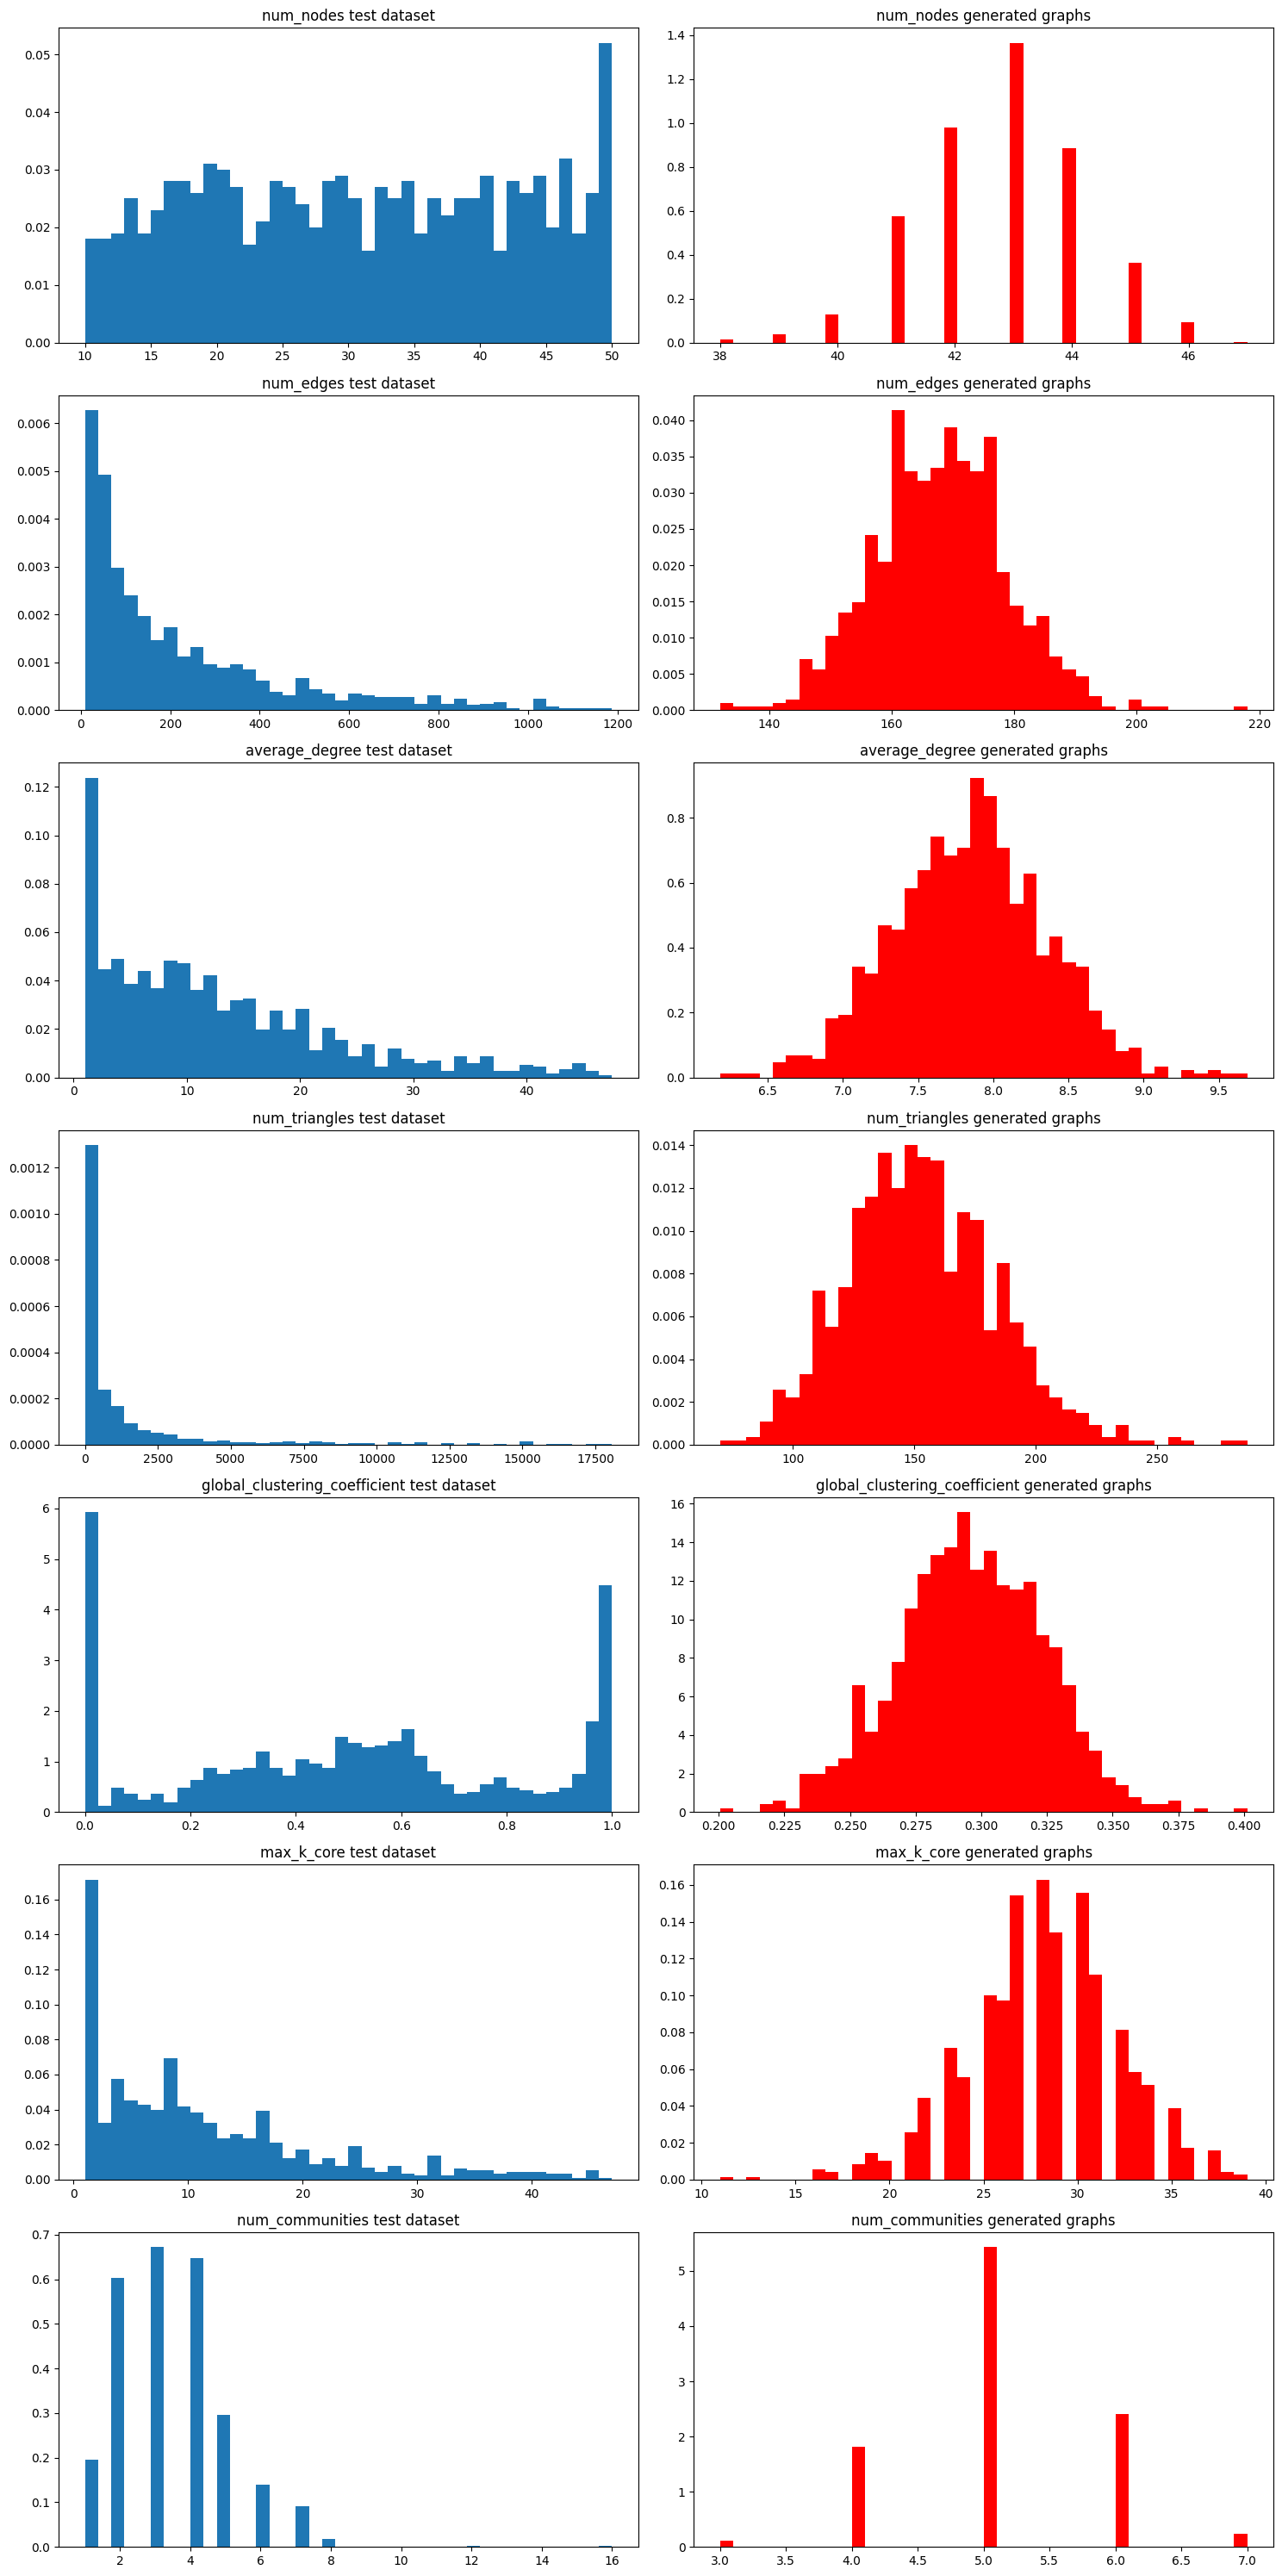

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
fig, axes = plt.subplots(7, 2, figsize=(15, 30))  # 7 rows, 2 columns

# Flatten axes array if it's 2D
axes = axes.flatten()

for i in range(7):
    # Plot ground_truth
    ax = axes[2 * i]
    ax.hist(ground_truth[:, i], density=True, bins=40)
    ax.set_title(f"{title[i]} test dataset")
    
    # Plot generated_stats
    ax = axes[2 * i + 1]
    ax.hist(pred[:, i], bins=40, color="r", density=True)
    ax.set_title(f"{title[i]} generated graphs")

plt.tight_layout()
plt.savefig("stats_test.png")
plt.show()